In [1]:
# Importando o PySpark
from pyspark.sql import SparkSession

In [2]:
# Criando uma sessão do Spark e adicionando o JAR spark-excel
spark = SparkSession.builder.appName('Análise Acidentes 2024') \
.config('spark.jars.package', 'com.crealytics:spark-excel_2.12:0.13.7') \
.getOrCreate()

In [3]:
# Caminho para o CSV
csv_file_path = '/content/acidentes2024_todas_causas_tipos_vs2.csv'

# Lendo o arquivo CSV com Pyspark, especificando o delimitador e codificação
df_spark = spark.read.csv(csv_file_path, header = True, sep=';', inferSchema=True, encoding='UTF-8')

# Exibindo o esquema da tabela
#df_spark.printSchema()

# Exibindo o DataFrame, somente as 5 primeiras linhas
df_spark.show(5)

+------+-------+------------+-------------+-------------------+---+---+-----+---------+---------------+--------------------+-------------------+--------------------+----------------------+-----------+-----------+----------------------+----------+--------------------+--------+----------+------------+--------------------+----------------------+--------------+-------------+-----+---------+------+-------------+--------------+------+--------------+--------------+--------+---------+--------------+
|    id|  pesid|data_inversa|   dia_semana|            horario| uf| br|   km|municipio|causa_principal|      causa_acidente|ordem_tipo_acidente|       tipo_acidente|classificacao_acidente|   fase_dia|sentido_via|condicao_metereologica|tipo_pista|         tracado_via|uso_solo|id_veiculo|tipo_veiculo|               marca|ano_fabricacao_veiculo|tipo_envolvido|estado_fisico|idade|     sexo|ilesos|feridos_leves|feridos_graves|mortos|      latitude|     longitude|regional|delegacia|           uop|
+-----

In [4]:
# Excluíndo os dados nullos do DataFrame
df_spark = df_spark.replace(["NA", "NULL"], None).na.drop(subset=["id", "data_inversa", "horario", "uf", "br", "km"])

In [5]:
# Excluíndo registros duplicados pela coluna id
df_distinct = df_spark.dropDuplicates(['id'])

In [6]:
# Fazendo contagem de acidentes por dia da semana
df_distinct.groupBy('dia_semana').count().orderBy('count', ascending=False).show()

+-------------+-----+
|   dia_semana|count|
+-------------+-----+
|      domingo|11719|
|       sábado|11623|
|  sexta-feira|11268|
|segunda-feira|10181|
| quinta-feira| 9541|
| quarta-feira| 9358|
|  terça-feira| 9280|
+-------------+-----+



In [7]:
# Fazendo contagem por condição metereologica e o tipo de pista
df_distinct.groupBy('condicao_metereologica', 'tipo_pista').count().orderBy('condicao_metereologica', ascending=True).show()

+----------------------+----------+-----+
|condicao_metereologica|tipo_pista|count|
+----------------------+----------+-----+
|                 Chuva|  Múltipla|  575|
|                 Chuva|   Simples| 3432|
|                 Chuva|     Dupla| 3397|
|             Céu Claro|     Dupla|19104|
|             Céu Claro|  Múltipla| 4389|
|             Céu Claro|   Simples|22665|
|        Garoa/Chuvisco|     Dupla| 1267|
|        Garoa/Chuvisco|  Múltipla|  267|
|        Garoa/Chuvisco|   Simples| 1232|
|               Granizo|     Dupla|    1|
|               Granizo|  Múltipla|    1|
|              Ignorado|     Dupla|  298|
|              Ignorado|  Múltipla|   80|
|              Ignorado|   Simples|  533|
|                  Neve|  Múltipla|    1|
|      Nevoeiro/Neblina|   Simples|  382|
|      Nevoeiro/Neblina|     Dupla|  235|
|      Nevoeiro/Neblina|  Múltipla|   39|
|               Nublado|  Múltipla| 1297|
|               Nublado|   Simples| 5098|
+----------------------+----------

In [8]:
from pyspark.sql.functions import round, avg

df_distinct.groupBy('br', 'uf') \
.agg(round(avg('km'), 2).alias('avg_km')) \
.orderBy('uf', ascending=True).show()

+---+---+------+
| br| uf|avg_km|
+---+---+------+
|307| AC| 185.0|
|317| AC|179.79|
|364| AC|148.35|
|316| AL|185.34|
|101| AL|127.07|
|110| AL|   2.0|
|104| AL| 65.24|
|423| AL|  67.0|
|424| AL| 98.57|
|416| AL|  32.5|
|230| AM|598.56|
|319| AM|222.63|
|317| AM| 452.0|
|174| AM|964.76|
|210| AP|  36.3|
|156| AP|492.69|
| 30| BA| 688.0|
|135| BA|147.28|
|420| BA|297.93|
|418| BA| 81.52|
+---+---+------+
only showing top 20 rows



In [9]:
# Filtrando média de km por UF = São Paulo
from pyspark.sql.functions import when, col
df_avgkm_br = df_distinct.filter(df_distinct.uf == 'SP') \
.groupBy('br') \
.agg(round(avg('km'), 2).alias('avg_km')) \
.orderBy('br', ascending=True)
df_avgkm_br.show()

+---+------+
| br|avg_km|
+---+------+
|101| 45.73|
|116|261.79|
|153|107.97|
|158|   7.0|
|262|320.25|
|381|  57.9|
|459| 24.33|
|488|   2.0|
+---+------+



In [10]:
# Importandando a biblioteca Pandas para a conversão do DataFrame spark para pandas
import pandas as pd
df_avgkm_br_pd = df_avgkm_br.toPandas()

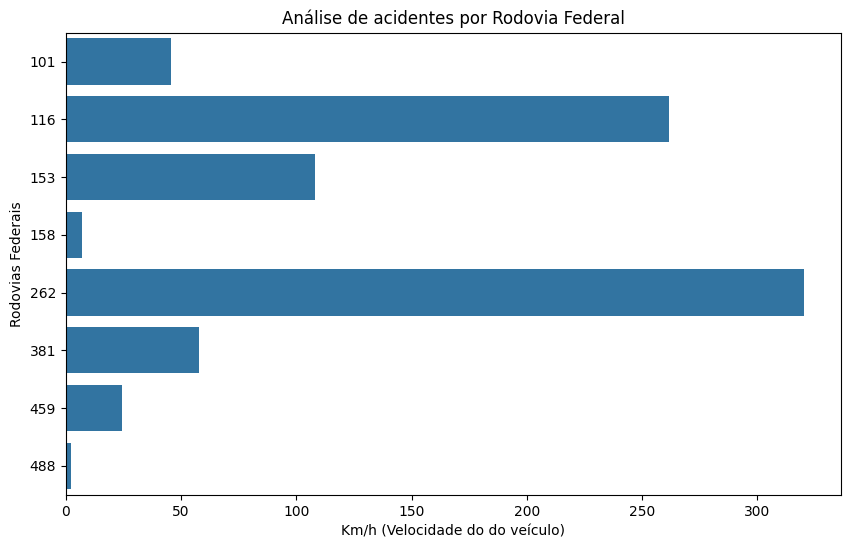

In [11]:
# Importação das biblioteca para a criação do gráfico
import matplotlib.pyplot as plt
import seaborn as sns

# Criação do gráfico
plt.figure(figsize=(10,6))
sns.barplot(x='avg_km', y='br', data=df_avgkm_br_pd)
plt.title('Análise de acidentes por Rodovia Federal')
plt.xlabel('Km/h (Velocidade do do veículo)')
plt.ylabel('Rodovias Federais')
plt.show()

In [12]:
# Código adicionado no dia 15/04, depois da segunda análise para averiguar, a quantidade de registro por Id
df_spark.groupBy('id').count().orderBy('count', ascending=False).show()

+------+-----+
|    id|count|
+------+-----+
|661121| 1540|
|594793|  960|
|651553|  960|
|660799|  945|
|615922|  920|
|614949|  864|
|579689|  792|
|651899|  792|
|589865|  650|
|622294|  575|
|659555|  558|
|648200|  549|
|581035|  532|
|639640|  480|
|645602|  468|
|651573|  460|
|602168|  450|
|574174|  408|
|617117|  408|
|617920|  408|
+------+-----+
only showing top 20 rows



In [13]:
# Finalizando a sessão do spark
spark.stop()